In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## Image segmentation with SAM 3

This notebook demonstrates how to use SAM 3 for image segmentation with text or visual prompts. It covers the following capabilities:

- **Text prompts**: Using natural language descriptions to segment objects (e.g., "person", "face")
- **Box prompts**: Using bounding boxes as exemplar visual prompts

In [ ]:
!hf auth login

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_image_predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [3]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

/scorpio/home/luyukuan/miniconda3/envs/diamond/lib/python3.12/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [5]:
import torch

# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# Build Model

Note: If error happens during file downloading, you should download files from [sam3 repo](https://huggingface.co/facebook/sam3/tree/main) yourself and set `checkpoint_path` argument.

In [18]:
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=f"/scorpio/home/luyukuan/projects/sam3/sam3.pt")

In [19]:
image_path = f"{sam3_root}/assets/images/atari_assault.jpg"
image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)

In [8]:
width, height

(768, 768)

# Text prompt

found 5 object(s)


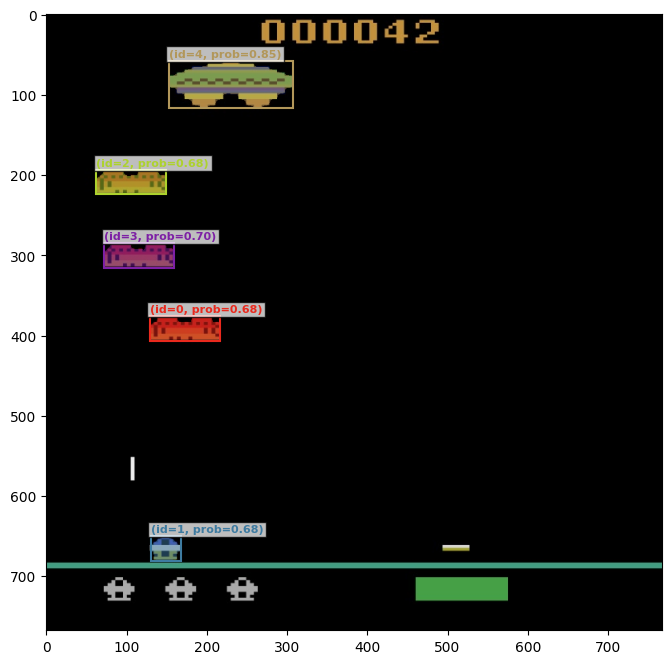

In [51]:
processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt="Spaceship")

img0 = Image.open(image_path)
plot_results(img0, inference_state)

### Visual prompt: a single bounding box

x = box 左上角的水平坐标（从图片左边开始向右数）

y = box 左上角的垂直坐标（从图片顶部开始向下数）

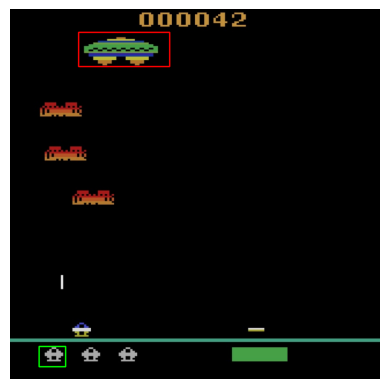

In [52]:
# Here the box is in  (x,y,w,h) format, where (x,y) is the top left corner.
# box_input_xywh = torch.tensor([480.0, 290.0, 110.0, 360.0]).view(-1, 4)
# box_input_xywh = torch.tensor([50.0, 184.0, 156 - 50, 244 - 184]).view(-1, 4)


box_input_xywh = [
    # [50.0, 184.0, 156 - 50, 244 - 184], 
    # [60, 276, 167 - 60, 326 - 276], 
    [60.0, 700.0, 116 - 60, 743 - 700],
    [142, 48, 332 - 142, 120 - 48],
    ]
box_input_cxcywh = box_xywh_to_cxcywh(torch.tensor(box_input_xywh).view(-1,4))
norm_boxes_cxcywh = normalize_bbox(box_input_cxcywh, width, height).tolist()

box_labels = [
    # True, 
    # True, 
    True, 
    False
    ]
# processor.reset_all_prompts(inference_state)

for box, label in zip(norm_boxes_cxcywh, box_labels):
    inference_state = processor.add_geometric_prompt(
        state=inference_state, box=box, label=label
    )

img0 = Image.open(image_path)
image_with_box = img0
for i in range(len(box_input_xywh)):
    if box_labels[i] == 1:
        color = (0, 255, 0)
    else:
        color = (255, 0, 0)
    image_with_box = draw_box_on_image(image_with_box, box_input_xywh[i], color)
plt.imshow(image_with_box)
plt.axis("off")  # Hide the axis
plt.show()

# box_input_xywh = torch.tensor([60.0, 700.0, 116 - 60, 743 - 700]).view(-1, 4)

# box_input_cxcywh = box_xywh_to_cxcywh(box_input_xywh)

# norm_box_cxcywh = normalize_bbox(box_input_cxcywh, width, height).flatten().tolist()
# print("Normalized box input:", norm_box_cxcywh)

# # processor.reset_all_prompts(inference_state)
# inference_state = processor.add_geometric_prompt(
#     state=inference_state, box=norm_box_cxcywh, label=True
# )

# img0 = Image.open(image_path)
# image_with_box = draw_box_on_image(img0, box_input_xywh.flatten().tolist())
# plt.imshow(image_with_box)
# plt.axis("off")  # Hide the axis
# plt.show()

found 8 object(s)


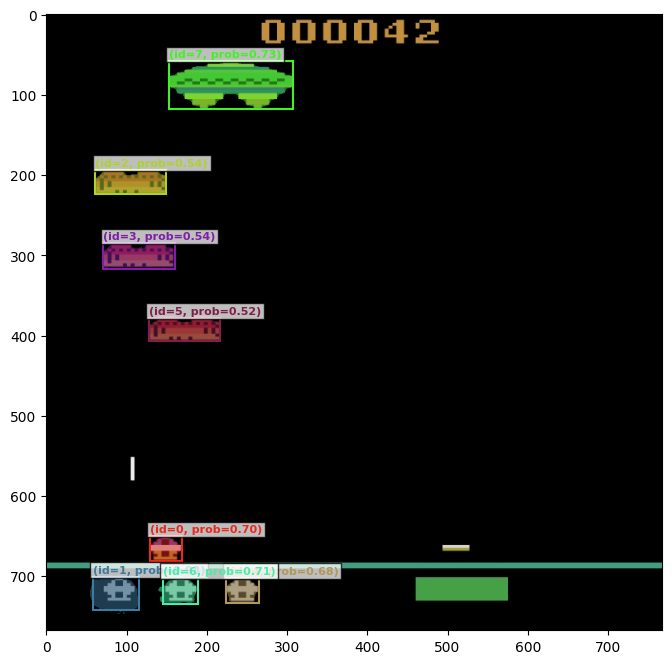

In [53]:
plot_results(img0, inference_state)

### Visual prompt: multi-box prompting (with positive and negative boxes)

In [ ]:
box_input_xywh = [[480.0, 290.0, 110.0, 360.0], [370.0, 280.0, 115.0, 375.0]]
box_input_cxcywh = box_xywh_to_cxcywh(torch.tensor(box_input_xywh).view(-1,4))
norm_boxes_cxcywh = normalize_bbox(box_input_cxcywh, width, height).tolist()

box_labels = [True, False]

processor.reset_all_prompts(inference_state)

for box, label in zip(norm_boxes_cxcywh, box_labels):
    inference_state = processor.add_geometric_prompt(
        state=inference_state, box=box, label=label
    )

img0 = Image.open(image_path)
image_with_box = img0
for i in range(len(box_input_xywh)):
    if box_labels[i] == 1:
        color = (0, 255, 0)
    else:
        color = (255, 0, 0)
    image_with_box = draw_box_on_image(image_with_box, box_input_xywh[i], color)
plt.imshow(image_with_box)
plt.axis("off")  # Hide the axis
plt.show()

In [ ]:
plot_results(img0, inference_state)